<a id="data-description"></a>
#  Data Description

**train.csv**
* timestamp: All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.
* Asset_ID: The asset ID corresponding to one of the crytocurrencies (e.g. Asset_ID = 1 for Bitcoin). The mapping from Asset_ID to crypto asset is contained in asset_details.csv.
* Count: Total number of trades in the time interval (last minute).
* Open: Opening price of the time interval (in USD).
* High: Highest price reached during time interval (in USD).
* Low: Lowest price reached during time interval (in USD).
* Close: Closing price of the time interval (in USD).
* Volume: Quantity of asset bought or sold, displayed in base currency USD.
* VWAP: The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.
* Target: Residual log-returns for the asset over a 15 minute horizon.

**supplemental_train.csv**
After the submission period is over this file's data will be replaced with cryptoasset prices from the submission period. In the Evaluation phase, the train, train supplement, and test set will be contiguous in time, apart from any missing data. The current copy, which is just filled approximately the right amount of data from train.csv is provided as a placeholder.

**asset_details.csv**
Provides the real name and of the cryptoasset for each Asset_ID and the weight each cryptoasset receives in the metric. Weights are determined by the logarithm of each product's market cap (in USD), of the cryptocurrencies at a fixed point in time. Weights were assigned to give more relevance to cryptocurrencies with higher market volumes to ensure smaller cryptocurrencies do not disproportionately impact the models.

**example_sample_submission.csv**
An example of the data that will be delivered by the time series API. The data is just copied from train.csv.

**example_test.csv**
An example of the data that will be delivered by the time series API.

In [1]:
### Importing libraries
import pandas as pd
import numpy as np
from datetime import datetime
from lightgbm import LGBMRegressor
import gresearch_crypto
import traceback
import time
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
### Loading datasets

path = "/kaggle/input/g-research-crypto-forecasting/"
df_train = pd.read_csv(path + "train.csv")
df_test = pd.read_csv(path + "example_test.csv")
df_asset_details = pd.read_csv(path + "asset_details.csv")
df_supp_train = pd.read_csv(path + "supplemental_train.csv")

In [3]:
df_train.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [4]:
df_test.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,group_num,row_id
0,1623542400,3,1201.0,1.478556,1.48603,1.47800,1.483681,654799.561103,1.481439,0,0
1,1623542400,2,1020.0,580.306667,583.89000,579.91000,582.276667,1227.988328,581.697038,0,1
2,1623542400,0,626.0,343.789500,345.10800,343.64000,344.598000,1718.832569,344.441729,0,2
3,1623542400,1,2888.0,35554.289632,35652.46465,35502.67000,35602.004286,163.811537,35583.469303,0,3
4,1623542400,4,433.0,0.312167,0.31260,0.31192,0.312208,585577.410442,0.312154,0,4


<a id="eda"></a>
#  Exploratory Data Analysis



In [5]:
df_train.describe()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423680e+07,2.348647e+07
mean,1.577120e+09,6.292544e+00,2.864593e+02,1.432640e+03,1.436350e+03,1.429568e+03,1.432640e+03,2.868530e+05,NaN,7.121752e-06
std,3.323350e+07,4.091861e+00,8.673982e+02,6.029605e+03,6.039482e+03,6.020261e+03,6.029611e+03,2.433935e+06,NaN,5.679042e-03
min,1.514765e+09,0.000000e+00,1.000000e+00,1.170400e-03,1.195000e-03,2.000000e-04,1.171400e-03,-3.662812e-01,-inf,-5.093509e-01
25%,1.549011e+09,3.000000e+00,1.900000e+01,2.676500e-01,2.681600e-01,2.669000e-01,2.676483e-01,1.410725e+02,2.676368e-01,-1.694354e-03
50%,1.578372e+09,6.000000e+00,6.400000e+01,1.428860e+01,1.431250e+01,1.426300e+01,1.428920e+01,1.295415e+03,1.428769e+01,-4.289844e-05
75%,1.606198e+09,9.000000e+00,2.210000e+02,2.288743e+02,2.293000e+02,2.284200e+02,2.288729e+02,2.729764e+04,2.288728e+02,1.601520e-03
max,1.632182e+09,1.300000e+01,1.650160e+05,6.480594e+04,6.490000e+04,6.467053e+04,6.480854e+04,7.597554e+08,inf,9.641699e-01


### Timestamp
We define a helper function that will turn a date format into a timestamp to use for indexing. 

In [6]:
# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

In [7]:
df_asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


There is a total of 14 unique coins in this dataset.

In [8]:
## Checking Time Range
btc = df_train[df_train["Asset_ID"]==1].set_index("timestamp") # Asset_ID = 1 for Bitcoin
eth = df_train[df_train["Asset_ID"]==6].set_index("timestamp") # Asset_ID = 6 for Ethereum
bnb = df_train[df_train["Asset_ID"]==0].set_index("timestamp") # Asset_ID = 0 for Binance Coin
ada = df_train[df_train["Asset_ID"]==3].set_index("timestamp") # Asset_ID = 3 for Cardano

beg_btc = datetime.fromtimestamp(btc.index[0]).strftime("%A, %B %d, %Y %I:%M:%S") 
end_btc = datetime.fromtimestamp(btc.index[-1]).strftime("%A, %B %d, %Y %I:%M:%S") 
beg_eth = datetime.fromtimestamp(eth.index[0]).strftime("%A, %B %d, %Y %I:%M:%S") 
end_eth = datetime.fromtimestamp(eth.index[-1]).strftime("%A, %B %d, %Y %I:%M:%S")
beg_bnb = datetime.fromtimestamp(eth.index[0]).strftime("%A, %B %d, %Y %I:%M:%S") 
end_bnb = datetime.fromtimestamp(eth.index[-1]).strftime("%A, %B %d, %Y %I:%M:%S")
beg_ada = datetime.fromtimestamp(eth.index[0]).strftime("%A, %B %d, %Y %I:%M:%S") 
end_ada = datetime.fromtimestamp(eth.index[-1]).strftime("%A, %B %d, %Y %I:%M:%S")

print('Bitcoin data goes from ', beg_btc, ' to ', end_btc) 
print('Ethereum data goes from ', beg_eth, ' to ', end_eth)
print('Binance coin data goes from ', beg_bnb, ' to ', end_bnb) 
print('Cardano data goes from ', beg_ada, ' to ', end_ada)

Bitcoin data goes from  Monday, January 01, 2018 12:01:00  to  Tuesday, September 21, 2021 12:00:00
Ethereum data goes from  Monday, January 01, 2018 12:01:00  to  Tuesday, September 21, 2021 12:00:00
Binance coin data goes from  Monday, January 01, 2018 12:01:00  to  Tuesday, September 21, 2021 12:00:00
Cardano data goes from  Monday, January 01, 2018 12:01:00  to  Tuesday, September 21, 2021 12:00:00


The data extends 4 years.

### Heatmap: Features of BTC

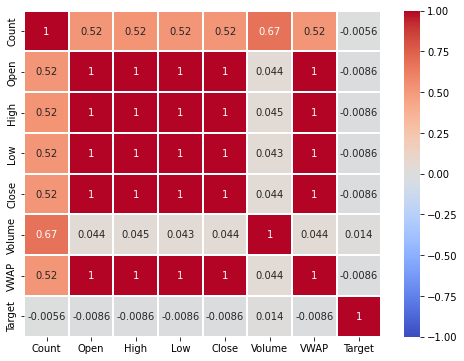

In [9]:
plt.figure(figsize=(8,6))
sns.heatmap(btc[['Count','Open','High','Low','Close','Volume','VWAP','Target']].corr(), 
            vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

### Candlesticks Charts for BTC & ETH, Last 200 Minutes

In [10]:
btc_mini = btc.iloc[-200:] # Select recent data rows
eth_mini = eth.iloc[-200:]

fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, open=btc_mini['Open'], high=btc_mini['High'], low=btc_mini['Low'], close=btc_mini['Close'])])
fig.update_xaxes(title_text="$")
fig.update_yaxes(title_text="Index")
fig.update_layout(title="Bitcoin Price, 200 Last Minutes")
fig.show()

fig = go.Figure(data=[go.Candlestick(x=eth_mini.index, open=eth_mini['Open'], high=eth_mini['High'], low=eth_mini['Low'], close=eth_mini['Close'])])
fig.update_xaxes(title_text="$")
fig.update_yaxes(title_text="Index")
fig.update_layout(title="Ethereum Price, 200 Last Minutes")
fig.show()

### Plotting BTC and ETH closing prices

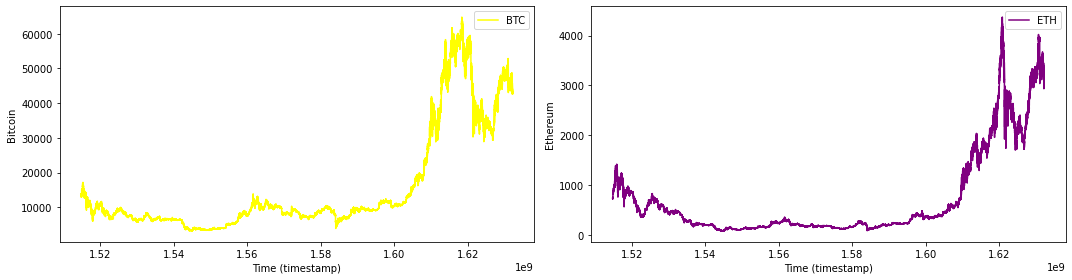

In [11]:
f = plt.figure(figsize=(15,4))

# fill NAs for BTC and ETH
btc = btc.reindex(range(btc.index[0],btc.index[-1]+60,60),method='pad')
eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='pad')

ax = f.add_subplot(121)
plt.plot(btc['Close'], color='yellow', label='BTC')
plt.legend()
plt.xlabel('Time (timestamp)')
plt.ylabel('Bitcoin')

ax2 = f.add_subplot(122)
ax2.plot(eth['Close'], color='purple', label='ETH')
plt.legend()
plt.xlabel('Time (timestamp)')
plt.ylabel('Ethereum')

plt.tight_layout()
plt.show()

### Heatmap: Coin Correlation (Last 10000 Minutes)

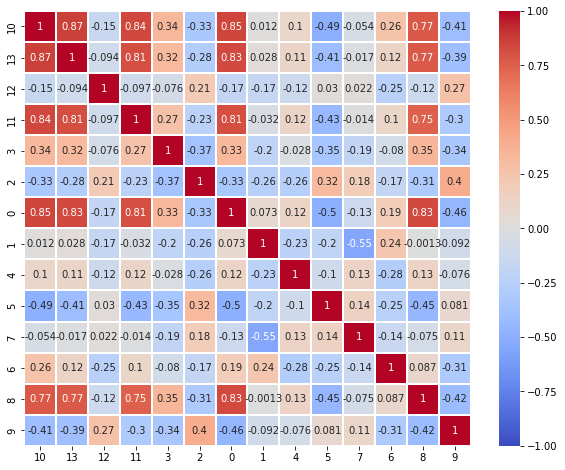

In [12]:
data =df_train[-10000:]
check = pd.DataFrame()
for i in data.Asset_ID.unique():
    check[i] = data[data.Asset_ID==i]['Target'].reset_index(drop=True) 
    
plt.figure(figsize=(10,8))
sns.heatmap(check.dropna().corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

Interestingly, in the last 10000 minutes we have several coins that are highly correlated with one another.

<a id="feature-extraction"></a>
##  Feature Extraction

We define a few functions to add to our list of features used for prediction.

In [13]:
def hlco_ratio(df): 
    return (df['High'] - df['Low'])/(df['Close']-df['Open'])
def upper_shadow(df):
    return df['High'] - np.maximum(df['Close'], df['Open'])
def lower_shadow(df):
    return np.minimum(df['Close'], df['Open']) - df['Low']

def get_features(df):
    df_feat = df[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
    df_feat['Upper_Shadow'] = upper_shadow(df_feat)
    df_feat['hlco_ratio'] = hlco_ratio(df_feat)
    df_feat['Lower_Shadow'] = lower_shadow(df_feat)
    return df_feat

##  Prediction



In [14]:
# train test split df_train into 80% train rows and 20% valid rows
train_data = df_train
# train_data = df_train.sample(frac = 0.8)
# valid_data = df_train.drop(train_data.index)

def get_Xy_and_model_for_asset(df_train, asset_id):
    df = df_train[df_train["Asset_ID"] == asset_id]
    
    df = df.sample(frac=0.2)
    df_proc = get_features(df)
    df_proc['y'] = df['Target']
    df_proc.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_proc = df_proc.dropna(how="any")
    
    
    X = df_proc.drop("y", axis=1)
    y = df_proc["y"]   
    model = LGBMRegressor()
    model.fit(X, y)
    return X, y, model

Xs = {}
ys = {}
models = {}

for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    X, y, model = get_Xy_and_model_for_asset(train_data, asset_id)       
    try:
        Xs[asset_id], ys[asset_id], models[asset_id] = X, y, model
    except: 
        Xs[asset_id], ys[asset_id], models[asset_id] = None, None, None 

Training model for Bitcoin Cash     (ID=2 )
Training model for Binance Coin     (ID=0 )
Training model for Bitcoin          (ID=1 )
Training model for EOS.IO           (ID=5 )
Training model for Ethereum Classic (ID=7 )
Training model for Ethereum         (ID=6 )
Training model for Litecoin         (ID=9 )
Training model for Monero           (ID=11)
Training model for TRON             (ID=13)
Training model for Stellar          (ID=12)
Training model for Cardano          (ID=3 )
Training model for IOTA             (ID=8 )
Training model for Maker            (ID=10)
Training model for Dogecoin         (ID=4 )


<a id="hyperparameter-tuning"></a>
## Evaluation, Hyperparam Tuning

We will perform GridSearch for each LGBM model of 14 coins.

### Hyperparameter Tuning

In [15]:
parameters = {
    # 'max_depth': range (2, 10, 1),
    'num_leaves': range(21, 161, 10),
    'learning_rate': [0.1, 0.01, 0.05]
}

new_models = {}
for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print("GridSearchCV for: " + asset_name)
    grid_search = GridSearchCV(
        estimator=get_Xy_and_model_for_asset(df_train, asset_id)[2], # bitcoin
        param_grid=parameters,
        n_jobs = -1,
        cv = 5,
        verbose=True
    )
    grid_search.fit(Xs[asset_id], ys[asset_id])
    new_models[asset_id] = grid_search.best_estimator_
    grid_search.best_estimator_


GridSearchCV for: Bitcoin Cash
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  4.4min finished


GridSearchCV for: Binance Coin
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  4.1min finished


GridSearchCV for: Bitcoin
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  5.0min finished


GridSearchCV for: EOS.IO
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  4.2min finished


GridSearchCV for: Ethereum Classic
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  4.1min finished


GridSearchCV for: Ethereum
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  4.3min finished


GridSearchCV for: Litecoin
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  4.4min finished


GridSearchCV for: Monero
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  3.3min finished


GridSearchCV for: TRON
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  4.2min finished


GridSearchCV for: Stellar
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  3.9min finished


GridSearchCV for: Cardano
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  4.0min finished


GridSearchCV for: IOTA
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  3.2min finished


GridSearchCV for: Maker
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  1.9min finished


GridSearchCV for: Dogecoin
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  2.0min finished


In [16]:
for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print(f"Tuned model for {asset_name:<1} (ID={asset_id:})")
    print(new_models[asset_id])

Tuned model for Bitcoin Cash (ID=2)
LGBMRegressor(learning_rate=0.01, num_leaves=91)
Tuned model for Binance Coin (ID=0)
LGBMRegressor(learning_rate=0.01, num_leaves=91)
Tuned model for Bitcoin (ID=1)
LGBMRegressor(learning_rate=0.05, num_leaves=131)
Tuned model for EOS.IO (ID=5)
LGBMRegressor(learning_rate=0.05, num_leaves=21)
Tuned model for Ethereum Classic (ID=7)
LGBMRegressor(learning_rate=0.05, num_leaves=21)
Tuned model for Ethereum (ID=6)
LGBMRegressor(learning_rate=0.05, num_leaves=81)
Tuned model for Litecoin (ID=9)
LGBMRegressor(learning_rate=0.01, num_leaves=141)
Tuned model for Monero (ID=11)
LGBMRegressor(learning_rate=0.05, num_leaves=21)
Tuned model for TRON (ID=13)
LGBMRegressor(learning_rate=0.01, num_leaves=141)
Tuned model for Stellar (ID=12)
LGBMRegressor(learning_rate=0.05, num_leaves=41)
Tuned model for Cardano (ID=3)
LGBMRegressor(learning_rate=0.01, num_leaves=71)
Tuned model for IOTA (ID=8)
LGBMRegressor(learning_rate=0.01, num_leaves=141)
Tuned model for Make